In [2]:
# 모듈 불러오기 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gc
import sys
import warnings

In [3]:
# 메모리 줄여주는 함수
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# 전처리 완료한 파일 불러오기 
train = pd.read_csv('loanuser_fin.csv')

train = reduce_mem_usage(train)

print(train.shape)

Memory usage of dataframe is 1293.21 MB --> 456.43 MB (Decreased by 64.7%)
(9970777, 17)


In [5]:
train = train.dropna(subset=['is_applied'])

In [6]:
train['is_applied'].unique()
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7595171 entries, 9818 to 9965020
Data columns (total 17 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   loan_limit                           float32
 1   loan_rate                            float32
 2   gender                               float32
 3   credit_score                         int8   
 4   yearly_income                        float32
 5   desired_amount                       float32
 6   personal_rehabilitation_yn           float32
 7   personal_rehabilitation_complete_yn  float32
 8   existing_loan_cnt                    float32
 9   existing_loan_amt                    float32
 10  work_day                             int16  
 11  Age                                  int8   
 12  label_purpose                        int8   
 13  label_employment_type                int8   
 14  label_houseown_type                  int8   
 15  label_income_type            

In [6]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install xgboost
# !pip install lightgbm
# !pip install sklearn

# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


In [30]:
X = train.drop('is_applied', axis=1)
y = train['is_applied']

In [31]:
y

9818       0.0
9819       0.0
9820       0.0
9821       0.0
9822       0.0
          ... 
9965016    0.0
9965017    0.0
9965018    0.0
9965019    0.0
9965020    0.0
Name: is_applied, Length: 7595171, dtype: float32

In [9]:
# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [32]:
# training set과 validation set의 데이터 수 확인
print('training set length :', len(X_train))
print('validation set length :', len(X_valid))

training set length : 6076136
validation set length : 1519035


In [11]:
# 1) features selection, 원 핫 인코딩
target = train['is_applied']
x_data = pd.get_dummies(train.loc[:, train.columns != 'is_applied'], drop_first =True)
#x_data = pd.get_dummies(hotel.drop('is_canceled', axis = 1), drop_first =True)

In [12]:
X_tn, X_te, y_tn, y_te = train_test_split(X, y,test_size=0.3)

In [13]:
# 라이브러리 불러오기
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [14]:
# 2) 표준화 스케일링
std = StandardScaler()
std.fit(X_tn)
X_tn_sc = std.transform(X_tn)
X_te_sc = std.transform(X_te)

In [15]:
##### Default 모델 확인
model = LogisticRegression()
model.fit(X_tn, y_tn)
print(model.score(X_te, y_te))

0.9455053033681039


In [16]:
# 3) 랜덤 포레스트 모델 학습
rf = RandomForestClassifier(random_state = 123, n_jobs = -1, max_depth= 15)
rf.fit(X_tn_sc, y_tn)
pred_te = rf.predict(X_te_sc)
pred_tn = rf.predict(X_tn_sc)

In [17]:
# 4) 모델 평가 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_te,pred_te)
print(cm)

[[2154035     348]
 [ 123550     619]]


Feature ranking:
1. feature loan_rate (0.211)
2. feature credit_score (0.200)
3. feature desired_amount (0.142)
4. feature loan_limit (0.085)
5. feature work_day (0.071)
6. feature label_income_type (0.069)
7. feature Age (0.053)
8. feature existing_loan_amt (0.049)
9. feature yearly_income (0.049)
10. feature label_purpose (0.023)
11. feature label_employment_type (0.019)
12. feature label_houseown_type (0.011)
13. feature existing_loan_cnt (0.009)
14. feature gender (0.007)
15. feature personal_rehabilitation_yn (0.002)
16. feature personal_rehabilitation_complete_yn (0.000)


<Figure size 432x288 with 0 Axes>

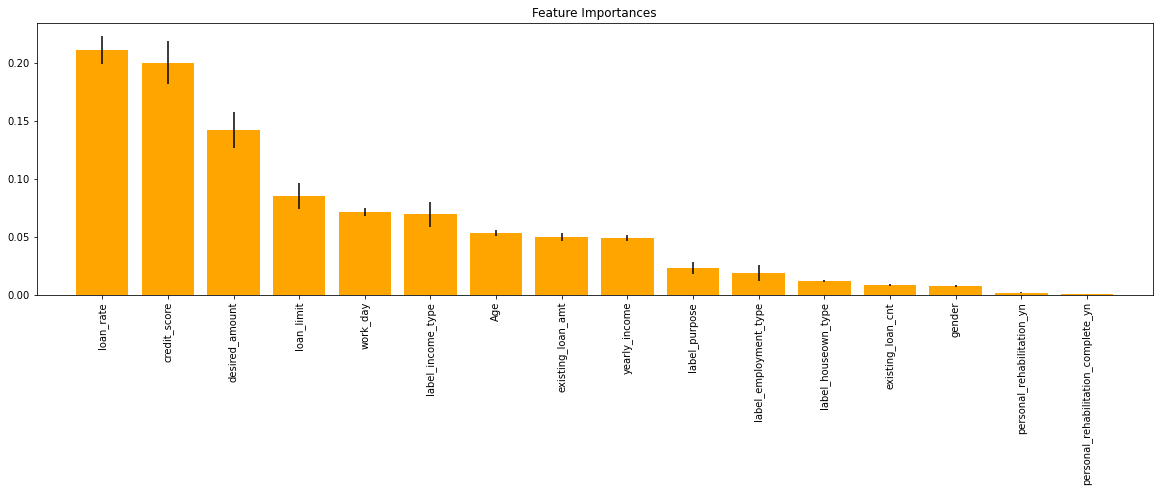

In [18]:
# Feature_importances 함수로 중요도 체크
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# 변수 중요도 출력
print("Feature ranking:")
for f in range(x_data.shape[1]):
    print("{}. feature {} ({:.3f})".format(f + 1, x_data.columns[indices][f], importances[indices[f]]))

# Feature Importances 변수중요도 시각화
plt.figure()
plt.figure(figsize=(20,5))
plt.title("Feature Importances")
plt.bar(range(x_data.shape[1]), importances[indices], color='orange',
        yerr=std[indices], align='center')
plt.xticks(range(x_data.shape[1]), x_data.columns[indices], rotation=90)
plt.xlim([-1, x_data.shape[1]])
plt.show()


In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV,KFold
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
import pandas as pd
import numpy as np
import gc
import os
import itertools
import sys
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import MinMaxScaler  

In [23]:
# xgboost
model_xgb = XGBRegressor(
    objective='reg:squarederror',
    booster = 'gbtree',
    colsample_bytree = 0.8,
    colsample_bylevel = 0.9,
    n_estimators = 200, 
    max_depth = 8, 
    min_child_weight=5, 
    learning_rate = 0.1 
)



# GradientBoostingRegressor
model_gbr = GradientBoostingRegressor(
    alpha = 0.9, 
    learning_rate=0.1, 
    max_depth = 7 ,
    n_estimators = 200 ,
    subsample = 0.9
    )

# Extra Trees Regressor
et_model=ExtraTreesRegressor( n_estimators = 200 ,
    max_depth = 12,
    min_samples_leaf = 8,
    min_samples_split =8,
    n_jobs = 5 )

# random forest
model_rf = RandomForestRegressor( n_estimators = 500 ,
    max_depth = 12,
    min_samples_leaf = 8,
    min_samples_split =8,
    n_jobs = 5 )

In [25]:
model_list = [model_xgb, model_gbr, et_model,model_rf]

In [26]:
for i in model_list:
  print(i)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.9, colsample_bynode=None, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None, ...)
GradientBoostingRegressor(max_depth=7, n_estimators=200, subsample=0.9)
ExtraTreesRegressor(max_depth=12, min_samples_leaf=8, min_samples_split=8,
                    n_estimators=200, n_jobs=5)
RandomForestRegressor(max_depth=12, min_samples_leaf=8, min_samples_split=8,
                

In [33]:
# 1
model = xgb.XGBRegressor()

# 2
param_grid={'booster' :['gbtree'],
                 'silent':[True], # default = 0, 1 = 동작메시지를 프린트하지 않음
                 'max_depth':[5,6,8], # 트리의 최대 깊이
                 'min_child_weight':[1,3,5], # over-fitting vs under-fitting을 조정하기 위한 파라미터
                 'gamma':[0,1,2,3], # 분할을 수행하는데 필요한 최소 손실 감소를 지정
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8], #  default = 1 , 각 트리마다의 feature 샘플링 비율.
                 'colsample_bylevel':[0.9], # 각 level마다 샘플링 비율
                 'n_estimators':[50],
                }


# 3번
cv=KFold(n_splits=6, random_state=1,shuffle=True)

# 4번
gcv=GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=4)

# 5번
gcv.fit(X_train.values,y_train.values)
print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력
print('best score', gcv.best_score_)      # 최고의 점수



KeyboardInterrupt: 

In [24]:
from sklearn.inspection import permutation_importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state = 1, max_depth = 15).fit(X_te, y_te)
eli5.show_weights(perm, feature_names = X_te.columns.tolist())

In [ ]:
features = dict() 

for i in permu.importances_mean.argsort()[::-1]:
    if permu.importances_mean[i] - 2 * permu.importances_std[i] > 0:
        features[x_data.columns[i]] = permu.importances[i]
        print(f"{x_data.columns[i]:<8}\t"
              f"{permu.importances_mean[i]:.3f}"    
              f" +/- {permu.importances_std[i]:.3f}")

In [34]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [35]:
# xgboost 성능 확인
get_clf_eval(y_valid, y_pred_xgb)

NameError: name 'y_pred_xgb' is not defined

In [ ]:
#### 조회 수 예측 모델링 ####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


X = train.drop('is_applied', axis=1)
y = train['is_applied']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras import backend as K


def coeff_determination(y_true, y_pred):
    SSE =  K.sum(K.square( y_true - y_pred ))
    SSR = K.sum(K.square( y_pred - np.mean(y_true) ) )
    SST = K.sum(K.square( y_true - np.mean(y_true) ) )
    return  tf.cast(SSR, tf.float64) / tf.cast(SST, tf.float64)

lr_train_avg, lr_val_avg,lr_valr_avg = 0, 0 ,0
ridge_train_avg, ridge_val_avg, ridge_valr_avg = 0, 0, 0
rf_train_avg, rf_val_avg, rf_valr_avg = 0, 0, 0
gbrt_train_avg, gbrt_val_avg, gbrt_valr_avg = 0, 0, 0
deep_train_avg, deep_val_avg ,deep_valr_avg= 0, 0,0


k = 1
for _ in range(k):
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)
    lr = LinearRegression().fit(X_tr, y_tr)
    #results = lr.predict(X_val)
    lr_train_avg += lr.score(X_tr, y_tr)
    lr_val_avg += lr.score(X_val, y_val)
    lr_valr_avg += lr.score(X_test, y_test)
    
    ridge = Ridge().fit(X_tr, y_tr)
    #results = ridge.predict(X_val)
    ridge_train_avg += ridge.score(X_tr, y_tr)
    ridge_val_avg += ridge.score(X_val, y_val)
    ridge_valr_avg += ridge.score(X_test, y_test)
    
    rf = RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
    rf.fit(X_tr, y_tr)
    #results = rf.predict(X_val)
    rf_train_avg += rf.score(X_tr, y_tr)
    rf_val_avg += rf.score(X_val, y_val)
    rf_valr_avg += rf.score(X_test, y_test)
    
    gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
    gbrt.fit(X_tr, y_tr)
    #results = gbrt.predict(X_val)
    gbrt_train_avg += gbrt.score(X_tr, y_tr)
    gbrt_val_avg += gbrt.score(X_val, y_val)
    gbrt_valr_avg += gbrt.score(X_test, y_test)
    
    leaky_relu = tf.nn.leaky_relu
    
    model = keras.Sequential([
    # 이 부분에서 레이어를 줄이거나 늘려보기!
    keras.layers.Dense(200, activation=leaky_relu, input_shape=(5,)),
    keras.layers.Dense(200, activation=leaky_relu),
    keras.layers.Dense(200, activation=leaky_relu),
    keras.layers.Dense(200, activation=leaky_relu),
    keras.layers.Dense(1, activation=leaky_relu),
    ])
    model.compile(loss ="MSE", optimizer="SGD" )
    history = model.fit(X_tr, y_tr, epochs=100, verbose=1)
    # 이부분에서 에포크 수를 줄이거나 늘려보기
    results = model.predict(X_val)
    results2=model.predict(X_test)
    
    #print(coeff_determination(y_val, results))
    
    deep_train_avg += coeff_determination(y_tr, model.predict(X_tr))
    deep_val_avg += coeff_determination(y_val, results)
    deep_valr_avg += coeff_determination(y_test, results2)

print("선형회귀 Training set score: {:.3f}".format(lr_train_avg/k))
print("선형회귀 Validation set score: {:.3f}".format(lr_val_avg/k))
print("선형회귀 Validation_real set score: {:.3f}".format(lr_valr_avg/k))
    
print("릿지회귀 Training set score: {:.3f}".format(ridge_train_avg/k))
print("릿지회귀 Validation set score: {:.3f}".format(ridge_val_avg/k))
print("릿지회귀 Validation_real set score: {:.3f}".format(ridge_valr_avg/k))
    
print("랜덤포레스트 Training set score: {:.3f}".format(rf_train_avg/k))
print("랜덤포레스트 Validation set score: {:.3f}".format(rf_val_avg/k))
print("랜덤포레스트 Validation_real set score: {:.3f}".format(rf_valr_avg/k))

print("GBRT Training set score: {:.3f}".format(gbrt_train_avg/k))
print("GBRT Validation set score: {:.3f}".format(gbrt_val_avg/k))
print("GBRT Validation_real set score: {:.3f}".format(gbrt_valr_avg/k))

print("신경망 Training set score: {:.10f}".format(deep_train_avg/k))
print("신경망 Validation set score: {:.10f}".format(deep_val_avg/k))
print("신경망 Validation_real set score: {:.10f}".format(deep_valr_avg/k))